In [8]:
import numpy as np
import pandas as pd

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint

seed = 42
np.random.seed(seed)

In [23]:
pdata = pd.read_csv('C:/Users/AMAN/Desktop/diabetes.csv')
pdata.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [42]:
pdata.describe()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [43]:
zero_fields = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

def check_zero_entries(data, fields):
    """ List number of 0-entries in each of the given fields"""
    for field in fields:
        print('field %s: num 0-entries: %d' % (field, len(data.loc[ data[field] == 0, field ])))

check_zero_entries(pdata, zero_fields)

field Glucose: num 0-entries: 5
field BloodPressure: num 0-entries: 35
field SkinThickness: num 0-entries: 227
field Insulin: num 0-entries: 374
field BMI: num 0-entries: 11


In [44]:
from sklearn.model_selection import train_test_split

features = list(pdata.columns.values)
features.remove('Outcome')
print(features)
X = pdata[features]
y = pdata['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']


In [45]:
print(X_train.shape)
print(X_test.shape)

(576, 8)
(192, 8)


In [46]:
def impute_zero_field(data, field):
    nonzero_vals = data.loc[data[field] != 0, field]
    avg = np.sum(nonzero_vals) / len(nonzero_vals)
    k = len(data.loc[ data[field] == 0, field])   # num of 0-entries
    data.loc[ data[field] == 0, field ] = avg
    print('Field: %s; fixed %d entries with value: %.3f' 
% (field, k, avg))

In [47]:
for field in zero_fields:
    impute_zero_field(X_train, field)

Field: Glucose; fixed 4 entries with value: 122.003
Field: BloodPressure; fixed 25 entries with value: 72.846
Field: SkinThickness; fixed 163 entries with value: 29.465
Field: Insulin; fixed 270 entries with value: 158.464
Field: BMI; fixed 8 entries with value: 32.663


C:\Users\AMAN\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [48]:
check_zero_entries(X_train, zero_fields)

field Glucose: num 0-entries: 0
field BloodPressure: num 0-entries: 0
field SkinThickness: num 0-entries: 0
field Insulin: num 0-entries: 0
field BMI: num 0-entries: 0


In [49]:
for field in zero_fields:
    impute_zero_field(X_test, field)

Field: Glucose; fixed 1 entries with value: 120.738
Field: BloodPressure; fixed 10 entries with value: 71.071
Field: SkinThickness; fixed 64 entries with value: 28.148
Field: Insulin; fixed 104 entries with value: 145.409
Field: BMI; fixed 3 entries with value: 31.841


In [50]:
check_zero_entries(X_test, zero_fields)


field Glucose: num 0-entries: 0
field BloodPressure: num 0-entries: 0
field SkinThickness: num 0-entries: 0
field Insulin: num 0-entries: 0
field BMI: num 0-entries: 0


In [51]:
X_train = X_train.values
y_train = y_train.values
X_test  = X_test.values
y_test  = y_test.values

In [59]:
NB_EPOCHS = 1000  # num of epochs to test for
BATCH_SIZE = 16

## Create our model
model = Sequential()

# 1st layer: input_dim=8, 12 nodes, RELU
model.add(Dense(12, input_dim=8, activation='relu'))
# 2nd layer: 8 nodes, RELU
model.add(Dense(8, activation='relu'))
# output layer: dim=1, activation sigmoid
model.add(Dense(1, activation='sigmoid' ))

# Compile the model
model.compile(loss='binary_crossentropy',   # since we are predicting 0/1
             optimizer='adam',
             metrics=['acc'])

# checkpoint: store the best model
ckpt_model = 'pima-weights.best.hdf5'
checkpoint = ModelCheckpoint(ckpt_model, 
                            monitor='val_acc',
                            verbose=1,
                            save_best_only=True,
                            mode='max')
callbacks_list = [checkpoint]

print('Starting training...')
# train the model, store the results for plotting
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_test, y_test),
                    epochs=NB_EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks_list,
                    verbose=0)

Starting training...

Epoch 00001: val_acc improved from -inf to 0.65625, saving model to pima-weights.best.hdf5

Epoch 00002: val_acc improved from 0.65625 to 0.67188, saving model to pima-weights.best.hdf5

Epoch 00003: val_acc improved from 0.67188 to 0.67708, saving model to pima-weights.best.hdf5

Epoch 00004: val_acc improved from 0.67708 to 0.69271, saving model to pima-weights.best.hdf5

Epoch 00005: val_acc did not improve from 0.69271

Epoch 00006: val_acc did not improve from 0.69271

Epoch 00007: val_acc did not improve from 0.69271

Epoch 00008: val_acc did not improve from 0.69271

Epoch 00009: val_acc improved from 0.69271 to 0.70312, saving model to pima-weights.best.hdf5

Epoch 00010: val_acc did not improve from 0.70312

Epoch 00011: val_acc did not improve from 0.70312

Epoch 00012: val_acc did not improve from 0.70312

Epoch 00013: val_acc did not improve from 0.70312

Epoch 00014: val_acc did not improve from 0.70312

Epoch 00015: val_acc did not improve from 0.703

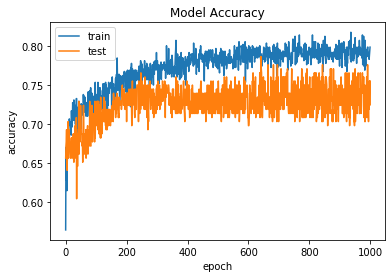

In [60]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

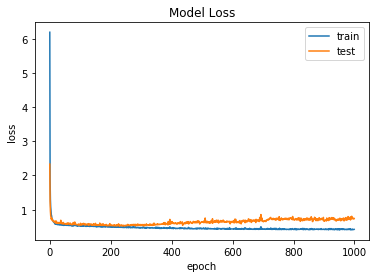

In [61]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

In [62]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 75.52%
